# Vanilla LSTM for Gene/No gene classification
The Milestone 1 corresponds to the classication task of, given a sequence, predict if it contains a gene, a partial sequence of a gene or just intergenic code.

In [0]:
!pip3 install pyfastx

     |████████████████████████████████| 768kB 2.8MB/s 


In [0]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import pandas as pd

from tqdm import tqdm # progress bar
from preproc_pipeline import window_pipeline
from warnings import simplefilter

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1. Dataset for training
The genome of E. coli will be used for this purpose.

In [0]:
simplefilter("ignore")
genome = "GCF_000008865.2_ASM886v2_genomic.fna"
feature_table = "GCA_000008865.2_ASM886v2_feature_table.tsv"
df = window_pipeline(genome, feature_table)

In [0]:
print(df.sequence.apply(lambda x: len(x)).max())
len(df)

50


36162

In [0]:
print(
    f"columns -> {list(df.columns)}\n"
    f"labels in dataframe -> {list(df.label.unique())}"
)

columns -> ['sequence', 'label']
labels in dataframe -> ['gene', 'intergenic', 'partial']


Let's get a one hot mapping for the labels.

In [0]:
labels = list(df.label.unique())
lab0 = np.zeros(len(labels))
lab2vec = {}
vec2lab = {}
for i, label in enumerate(list(df.label.unique())):
    labv = lab0.copy()
    labv[i] = 1
    lab2vec[label] = labv
    vec2lab[tuple(labv)] = label

print(f"lab2vec -> {lab2vec}\nvec2lab -> {vec2lab}")

lab2vec -> {'gene': array([1., 0., 0.]), 'intergenic': array([0., 1., 0.]), 'partial': array([0., 0., 1.])}
vec2lab -> {(1.0, 0.0, 0.0): 'gene', (0.0, 1.0, 0.0): 'intergenic', (0.0, 0.0, 1.0): 'partial'}


In [0]:
print(df[df.sequence.apply(lambda x: len(x)==0)].count())
df = df[~df.sequence.apply(lambda x: len(x)==0)]

sequence    0
label       0
dtype: int64


Need to check why it always generate a 0 length row. I think is the last one, but I am not sure.

In [0]:
df["label_onehot"] = df.label.apply(lambda x: lab2vec[x])
toy = pd.concat([df[df.label=="gene"].sample(n=2000),
                df[df.label=="intergenic"].sample(n=2000),
                df[df.label=="partial"].sample(n=2000)]).reset_index(drop=True)
df_train = toy.sample(frac=8/10) # shuffle
df_test = toy[~toy.sequence.isin(df_train.sequence)].reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_train

,sequence,label,label_onehot
0,TATTAATAAAACCTTCTGGGTCAGATATCTCAATAAATATCATATC...,intergenic,"[0.0, 1.0, 0.0]"
1,AATGTAAAGCTGGCCCTGAGAATTATCCGCCGATTGGTGTTGTTTC...,intergenic,"[0.0, 1.0, 0.0]"
2,CATCAACGCCCTGATCAAATTGTTTGCTGATGTCCATAATATAACC...,partial,"[0.0, 0.0, 1.0]"
3,TCACCTCGTTGTCATATAGCGAGAGCGGGGAGTTTTTGAATTATTC...,partial,"[0.0, 0.0, 1.0]"
4,AGGCTGAAATTCGCGATATCGCGCTGACCATCCCTAACCTGCCTGC...,partial,"[0.0, 0.0, 1.0]"
...,...,...,...
4795,TCGTAAAAAGGGGCAGCGTTCATCCCTGAAAGGTGGCGGCAGCGTG...,gene,"[1.0, 0.0, 0.0]"
4796,CGCGTTTCACGGGATTTCACAGAGCCGCCGCCAGTAGCCAGCACAA...,partial,"[0.0, 0.0, 1.0]"
4797,AATGATGTATTCAGGGCCAAAGCTCAGATCCTGATCGCCATACGCT...,gene,"[1.0, 0.0, 0.0]"
4798,TATTGAGTTACGACCTCGTTACCGTTAACGATGGTCTTGGTGATTT...,gene,"[1.0, 0.0, 0.0]"


## 2. Embeddings
The next step is to use the whole sequence to compute the embeddings. First, get a set of k-mers, that will be our words for this NLP problem.

In [0]:
def window(fseq, window_size, slide = 1):
    # create a window of size k
    N = len(fseq)
    for i in range(0, N - window_size + 1, slide):
      if i+window_size+slide < N:
        yield fseq[i:i+window_size]


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

def get_index_of_max(input):
    index = 0
    for i in range(1, len(input)):
        if input[i] > input[index]:
            index = i 
    return index

def get_max_prob_result(input, ix_to_word):
    return ix_to_word[get_index_of_max(input)]

class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, padding_idx):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, 
                                       padding_idx=padding_idx) #used predefined nn.Embedding
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.LongTensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)
    
k = 3                     # so our words has length 3
SLIDE = 1                 # sampling slide
CONTEXT_SIZE = 2          # 2 words to the left, 2 to the right
EMDEDDING_DIM = 25        # embedding dimension
EPOCHS = 30               # number of epochs for training
model = None              # CBOW model

Finally, gather all the kmers and apply the CBOW algorithm.

In [0]:
# Since we have the embeddings stored, we are going to ignore the following next
# two cells and use this one instead
stored = True

if stored:
  with open("/content/drive/My Drive/wti.p", "rb") as f:
    word_to_ix = pickle.load(f)
  ix_to_word = {v: k for k,v in word_to_ix.items()}
  model_save_name = 'ma_model.pt'
  path = model_save_name
  path = F"/content/drive/My Drive/{model_save_name}" 
  model = CBOW(len(word_to_ix), EMDEDDING_DIM, padding_idx=word_to_ix["X"]).cpu()
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [0]:
# kmer in all of the 1/4 sequences of the dataset
kmers = [ kmer for kmer in window("".join([seq for seq in df_train.loc[:,"sequence"]]), k, SLIDE) ]  
vocab_size = len(kmers)

data = []
print("Filling context data...")
pbar = tqdm(total=vocab_size - 4-1) # just to output something in screen
for i in range(2, vocab_size - 2): # first word to have 2 words before is the "third" one (0,1,2)
    context = (kmers[i - 2], kmers[i - 1],
               kmers[i + 1], kmers[i + 2])
    target = kmers[i]
    data.append((context, target))
    pbar.update(1)

word_to_ix, ix_to_word = {},{}
for i, word in enumerate(set(kmers)):
    word_to_ix[word] = i
    ix_to_word[i] = word

ix = len(ix_to_word)
ix_to_word[ix] = "X"  # our padding character
word_to_ix["X"] = ix

with open("/content/drive/My Drive/wti.p", "wb") as f:
  pickle.dump(word_to_ix, f)

with open("/content/drive/My Drive/itw.p", "wb") as f:
  pickle.dump(ix_to_word, f)

  0%|          | 0/79991 [00:00<?, ?it/s]

Filling context data...


 27%|██▋       | 21343/79991 [00:00<00:00, 213423.59it/s]

In [0]:
import sys
from time import time 
model = CBOW(len(word_to_ix), EMDEDDING_DIM, padding_idx=word_to_ix["X"])

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
print("Training embeddings...")

model_save_name = 'ma_model.pt'
path = F"/content/drive/My Drive/{model_save_name}" 

start = time()
tot = len(data)
print()
for epoch in range(EPOCHS):
  start = time()
  total_loss = 0
  i = 1
  for context, target in data:
    if not i%100:
      sys.stdout.write(f"\r{i}/{tot} in {round(time()-start,2)}s        ")
      sys.stdout.flush()
    context_vector = make_context_vector(context, word_to_ix)  
    model.zero_grad()
    log_probs = model(context_vector)
    loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
    loss.backward()
    optimizer.step()
    total_loss += loss.data
    i+=1
  torch.save(model.state_dict(), path)
  print(f"\nEpoch {epoch+1}/{EPOCHS} in {round(time()-start,2)}\n\n")

Training embeddings...

27700/79992 in 19.74s        

79992it [00:20, 213423.59it/s]                           

79900/79992 in 56.32s        
Epoch 1/30 in 56.38836646080017


79900/79992 in 55.63s        
Epoch 2/30 in 55.700063705444336


79900/79992 in 58.94s        
Epoch 3/30 in 59.00810956954956


79900/79992 in 58.34s        
Epoch 4/30 in 58.411818742752075


79900/79992 in 57.09s        
Epoch 5/30 in 57.166804790496826


79900/79992 in 57.6s        
Epoch 6/30 in 57.665950298309326


79900/79992 in 56.33s        
Epoch 7/30 in 56.40046310424805


79900/79992 in 57.23s        
Epoch 8/30 in 57.31258416175842


79900/79992 in 56.69s        
Epoch 9/30 in 56.76210379600525


79900/79992 in 57.19s        
Epoch 10/30 in 57.25938630104065


79900/79992 in 57.71s        
Epoch 11/30 in 57.78800010681152


79900/79992 in 57.93s        
Epoch 12/30 in 58.00145125389099


79900/79992 in 56.46s        
Epoch 13/30 in 56.535449266433716


79900/79992 in 57.09s        
Epoch 14/30 in 57.15931820869446


79900/79992 in 56.69s        
Epoch 15/30 in 56.76209354400635


79900/79992 in 57.24s        


## 4. Vanilla RNN model

In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, lstm_layers,
                 hidden_out, output_dim, padding_idx, t):

        super().__init__()
        self.nb_tags = output_dim

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=padding_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, 
                           num_layers=lstm_layers)# ,dropout=0.4)

        self.fnn2 = nn.Sequential(
            nn.Linear(t*hidden_dim*2, hidden_out),
           # nn.BatchNorm1d(hidden_out), 
            nn.ReLU(),
           # nn.AlphaDropout(),
            nn.Linear(hidden_out, output_dim)
        )        


    def forward(self, text):

        #text = [sent len, batch size]
        # 1. embedding
        embedded = self.embedding(text)

        # 2. LSTM
        output, (hidden, lt) = self.rnn(embedded)

        # 3. get that so it's correctly packed for the hidden layer
        output = output.contiguous()
        output = output.reshape(output.shape[0], -1)

        # 4. classification through the 2 FF layers
        output = self.fnn2(output)
        return output

## 4. Tweak the embeddings to accomodate varying sizes of the sequences
Once we have the model and the embeddings, we would need to tweak the embeddings so that they are adjusted for the padded sequences.

### 4.1. Add the padding char to the embeddings

Now, get sequences as indexes.

In [0]:
def to_ix(kmer, word_to_ix):
  if "X" in kmer:
    return word_to_ix["X"]
  elif kmer in word_to_ix:
    return word_to_ix[kmer]
  else:
    return len(word_to_ix)

def wind_idx(seq):
  return [to_ix(kmer, word_to_ix)  for kmer in window(seq, k, SLIDE)]

df_train["seq_idx"] = df_train["sequence"].apply(wind_idx)
df_test["seq_idx"] = df_test["sequence"].apply(wind_idx)

In [0]:
np.unique(df_train["seq_idx"].apply(lambda x: len(x)))

array([46])

Finally, instantiante the model and initialize the weigths of the embeddings.

In [0]:
print(word_to_ix["X"])
print(len(set(word_to_ix.keys()))-1)

64
64


In [0]:
t = len(df_train.iloc[0,0]) # Find length of seqs (fixed)

rnn = RNN(input_dim=len(word_to_ix), embedding_dim=EMDEDDING_DIM,
          hidden_dim = 30, lstm_layers=1, hidden_out = 140, output_dim=3, 
          padding_idx = word_to_ix["X"], t = len(df_train.iloc[0,3])).cuda()

In [0]:
rnn.embedding.weight.data.copy_(model.embeddings.weight).cuda()
# optimizer = torch.optim.SGD(rnn.parameters(), lr=1e-3)
optimizer = torch.optim.ASGD(rnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().cuda()

## 5. Training loop


All that is left is to split our training and testing and train the model.

In [0]:
from torch.utils.data import DataLoader, Dataset

class oversampdata(Dataset):
  def __init__(self, data):
    # first column is list of index sentence
    self.data = torch.LongTensor(data.iloc[:,0])
    # second column is the label
    self.targets = torch.LongTensor(data.iloc[:,1])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_val = self.data[index]
    target = self.targets[index]
    return data_val, target

train_dataset = oversampdata(df_train.loc[:,["seq_idx", "label_onehot"]])
valid_dataset = oversampdata(df_test.loc[:,["seq_idx", "label_onehot"]])

In [0]:
BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                                         shuffle=True)

In [0]:
def binary_accuracy(preds, y):
   """
   Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
   """
   rounded_preds = torch.zeros(preds.size())
   for i in range(len(preds)):
     idx_max = torch.where(preds[i] == preds[i].max())
     rounded_preds[i][idx_max] = 1
   rounded_preds = torch.FloatTensor(rounded_preds).int()
   correct = (rounded_preds == y).float() #convert into float for division
   acc = (correct.sum()/len(preds[0])) / len(correct)
   return acc

In [0]:
from torch.autograd import Variable
import sys
import matplotlib.pyplot as plt
# Colab in dark mode, guys :)
plt.style.use(['seaborn-dark', 'dark_background'])

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    print("Training...")

    for i, batch in enumerate(iterator):
        if i%10:
          sys.stdout.write(f"\rIteration {i}        ")
          sys.stdout.flush()

        inputs, labels_onehot = batch

        inputs = Variable(inputs).cuda()

        optimizer.zero_grad()
                
        predictions = model(inputs)
        
        labels_idx = torch.LongTensor([np.where(label==1)[0][0] for label in labels_onehot]).cuda()


        loss = criterion(predictions, labels_idx)
        
        loss.backward()
        
        optimizer.step()
        
        acc = binary_accuracy(predictions, labels_onehot)
        # print(loss.item())
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    print("Evaluating...")

    for i, batch in enumerate(iterator):

        inputs, labels_onehot = batch
        inputs = inputs.cuda()
        predictions = model(inputs)
        labels_idx = torch.LongTensor([np.where(label==1)[0][0] for label in labels_onehot]).cuda()

        loss = criterion(predictions, labels_idx)
        acc = binary_accuracy(predictions, labels_onehot)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def plot_network(epochs, train_loss, test_loss):
    """ Neon """
    plt.figure()
    # Other Neon colors of the palette -> #13CA91 #3B27BA #E847AE #FF9472
    plt.plot(epochs, train_loss, color='#13CA91', marker = "o", linestyle='-', label='Training loss',)
    plt.plot(epochs, test_loss, color='#3B27BA', marker = "o", linestyle='-', label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('NLL')
    plt.show()
    

Epoch: 0
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.099 | Train Acc: 55.96%
	 Val. Loss: 1.098 |  Val. Acc: 56.40%
Epoch: 1
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.099 | Train Acc: 55.89%
	 Val. Loss: 1.098 |  Val. Acc: 54.75%
Epoch: 2
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.098 | Train Acc: 56.15%
	 Val. Loss: 1.098 |  Val. Acc: 56.70%
Epoch: 3
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.098 | Train Acc: 56.94%
	 Val. Loss: 1.098 |  Val. Acc: 55.88%
Epoch: 4
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.098 | Train Acc: 57.14%
	 Val. Loss: 1.098 |  Val. Acc: 55.90%
Epoch: 5
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.098 | Train Acc: 57.75%
	 Val. Loss: 1.098 |  Val. Acc: 55.18%
Epoch: 6
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.098 | Train Acc: 57.15%
	 Val. Loss: 1.098 |  Val. Acc: 56.86%
Epoch: 7
Training...
Iteration 149        
Evaluating..

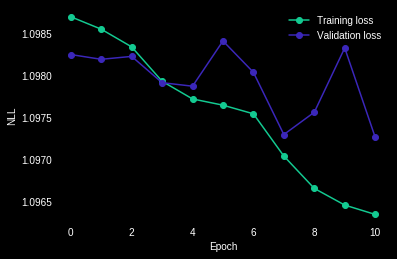

Epoch: 11
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.096 | Train Acc: 58.83%
	 Val. Loss: 1.097 |  Val. Acc: 56.40%
Epoch: 12
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.096 | Train Acc: 58.69%
	 Val. Loss: 1.097 |  Val. Acc: 56.29%
Epoch: 13
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.096 | Train Acc: 58.90%
	 Val. Loss: 1.097 |  Val. Acc: 57.93%
Epoch: 14
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.095 | Train Acc: 59.38%
	 Val. Loss: 1.097 |  Val. Acc: 56.34%
Epoch: 15
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.096 | Train Acc: 58.94%
	 Val. Loss: 1.097 |  Val. Acc: 56.56%
Epoch: 16
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.095 | Train Acc: 59.71%
	 Val. Loss: 1.097 |  Val. Acc: 57.80%
Epoch: 17
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.095 | Train Acc: 60.18%
	 Val. Loss: 1.096 |  Val. Acc: 58.34%
Epoch: 18
Training...
Iteration 149        
Eval

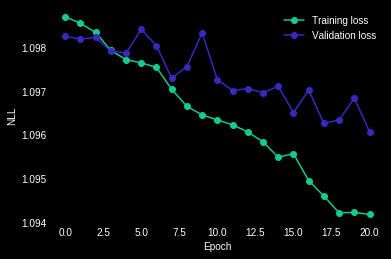

Epoch: 21
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.094 | Train Acc: 61.00%
	 Val. Loss: 1.096 |  Val. Acc: 57.99%
Epoch: 22
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.093 | Train Acc: 61.17%
	 Val. Loss: 1.096 |  Val. Acc: 57.63%
Epoch: 23
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.093 | Train Acc: 61.38%
	 Val. Loss: 1.095 |  Val. Acc: 58.67%
Epoch: 24
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.093 | Train Acc: 61.19%
	 Val. Loss: 1.095 |  Val. Acc: 59.71%
Epoch: 25
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.093 | Train Acc: 61.82%
	 Val. Loss: 1.096 |  Val. Acc: 58.17%
Epoch: 26
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.092 | Train Acc: 61.72%
	 Val. Loss: 1.095 |  Val. Acc: 60.20%
Epoch: 27
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.092 | Train Acc: 61.71%
	 Val. Loss: 1.094 |  Val. Acc: 59.06%
Epoch: 28
Training...
Iteration 149        
Eval

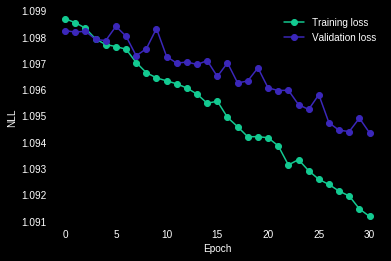

Epoch: 31
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.091 | Train Acc: 63.28%
	 Val. Loss: 1.094 |  Val. Acc: 58.67%
Epoch: 32
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.090 | Train Acc: 63.49%
	 Val. Loss: 1.094 |  Val. Acc: 60.04%
Epoch: 33
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.090 | Train Acc: 63.22%
	 Val. Loss: 1.094 |  Val. Acc: 58.83%
Epoch: 34
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.090 | Train Acc: 64.00%
	 Val. Loss: 1.094 |  Val. Acc: 59.64%
Epoch: 35
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.090 | Train Acc: 63.43%
	 Val. Loss: 1.094 |  Val. Acc: 61.36%
Epoch: 36
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.089 | Train Acc: 63.31%
	 Val. Loss: 1.093 |  Val. Acc: 59.41%
Epoch: 37
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.089 | Train Acc: 64.31%
	 Val. Loss: 1.093 |  Val. Acc: 59.49%
Epoch: 38
Training...
Iteration 149        
Eval

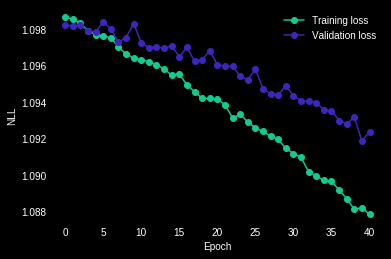

Epoch: 41
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.087 | Train Acc: 64.53%
	 Val. Loss: 1.093 |  Val. Acc: 60.40%
Epoch: 42
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.087 | Train Acc: 64.97%
	 Val. Loss: 1.092 |  Val. Acc: 60.02%
Epoch: 43
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.087 | Train Acc: 64.92%
	 Val. Loss: 1.092 |  Val. Acc: 60.23%
Epoch: 44
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.086 | Train Acc: 65.37%
	 Val. Loss: 1.092 |  Val. Acc: 60.98%
Epoch: 45
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.086 | Train Acc: 65.51%
	 Val. Loss: 1.090 |  Val. Acc: 61.93%
Epoch: 46
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.085 | Train Acc: 66.22%
	 Val. Loss: 1.090 |  Val. Acc: 62.37%
Epoch: 47
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.084 | Train Acc: 65.93%
	 Val. Loss: 1.090 |  Val. Acc: 61.71%
Epoch: 48
Training...
Iteration 149        
Eval

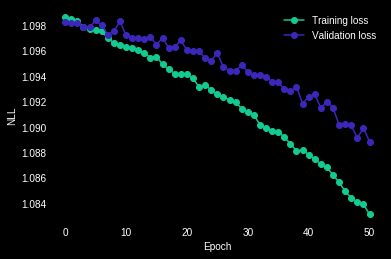

Epoch: 51
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.083 | Train Acc: 66.79%
	 Val. Loss: 1.089 |  Val. Acc: 62.21%
Epoch: 52
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.083 | Train Acc: 66.43%
	 Val. Loss: 1.090 |  Val. Acc: 61.30%
Epoch: 53
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.082 | Train Acc: 66.83%
	 Val. Loss: 1.088 |  Val. Acc: 63.06%
Epoch: 54
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.081 | Train Acc: 67.46%
	 Val. Loss: 1.088 |  Val. Acc: 62.71%
Epoch: 55
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.081 | Train Acc: 67.51%
	 Val. Loss: 1.088 |  Val. Acc: 62.79%
Epoch: 56
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.080 | Train Acc: 68.64%
	 Val. Loss: 1.087 |  Val. Acc: 63.52%
Epoch: 57
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.079 | Train Acc: 68.03%
	 Val. Loss: 1.087 |  Val. Acc: 61.88%
Epoch: 58
Training...
Iteration 149        
Eval

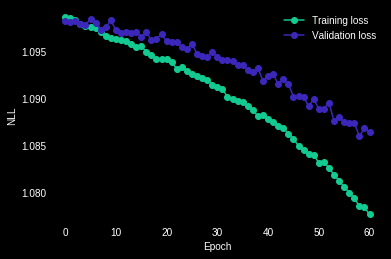

Epoch: 61
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.078 | Train Acc: 68.78%
	 Val. Loss: 1.084 |  Val. Acc: 63.66%
Epoch: 62
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.077 | Train Acc: 68.64%
	 Val. Loss: 1.085 |  Val. Acc: 64.42%
Epoch: 63
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.076 | Train Acc: 67.93%
	 Val. Loss: 1.085 |  Val. Acc: 63.52%
Epoch: 64
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.075 | Train Acc: 68.99%
	 Val. Loss: 1.084 |  Val. Acc: 64.63%
Epoch: 65
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.075 | Train Acc: 69.19%
	 Val. Loss: 1.084 |  Val. Acc: 63.19%
Epoch: 66
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.074 | Train Acc: 69.04%
	 Val. Loss: 1.083 |  Val. Acc: 63.55%
Epoch: 67
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.074 | Train Acc: 68.47%
	 Val. Loss: 1.082 |  Val. Acc: 65.54%
Epoch: 68
Training...
Iteration 149        
Eval

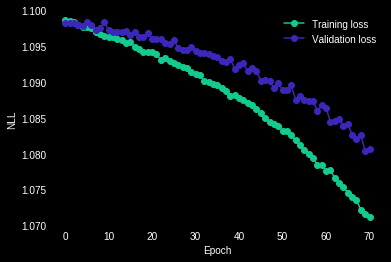

Epoch: 71
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.070 | Train Acc: 69.54%
	 Val. Loss: 1.081 |  Val. Acc: 63.58%
Epoch: 72
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.070 | Train Acc: 69.01%
	 Val. Loss: 1.079 |  Val. Acc: 64.46%
Epoch: 73
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.069 | Train Acc: 69.46%
	 Val. Loss: 1.078 |  Val. Acc: 65.25%
Epoch: 74
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.067 | Train Acc: 70.10%
	 Val. Loss: 1.078 |  Val. Acc: 64.57%
Epoch: 75
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.066 | Train Acc: 69.71%
	 Val. Loss: 1.079 |  Val. Acc: 63.80%
Epoch: 76
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.066 | Train Acc: 70.15%
	 Val. Loss: 1.077 |  Val. Acc: 65.03%
Epoch: 77
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.065 | Train Acc: 70.11%
	 Val. Loss: 1.078 |  Val. Acc: 64.89%
Epoch: 78
Training...
Iteration 149        
Eval

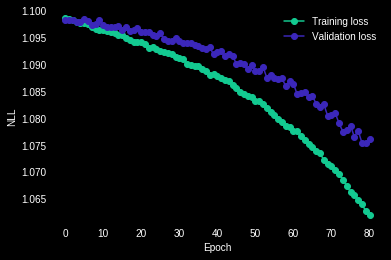

Epoch: 81
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.061 | Train Acc: 70.14%
	 Val. Loss: 1.073 |  Val. Acc: 65.02%
Epoch: 82
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.060 | Train Acc: 70.51%
	 Val. Loss: 1.074 |  Val. Acc: 65.64%
Epoch: 83
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.060 | Train Acc: 70.65%
	 Val. Loss: 1.074 |  Val. Acc: 64.87%
Epoch: 84
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.058 | Train Acc: 70.92%
	 Val. Loss: 1.071 |  Val. Acc: 65.78%
Epoch: 85
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.057 | Train Acc: 70.56%
	 Val. Loss: 1.069 |  Val. Acc: 65.36%
Epoch: 86
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.055 | Train Acc: 70.46%
	 Val. Loss: 1.071 |  Val. Acc: 65.39%
Epoch: 87
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.055 | Train Acc: 70.76%
	 Val. Loss: 1.070 |  Val. Acc: 64.43%
Epoch: 88
Training...
Iteration 149        
Eval

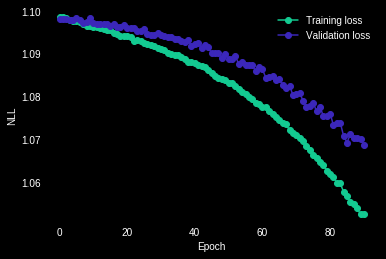

Epoch: 91
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.051 | Train Acc: 70.92%
	 Val. Loss: 1.067 |  Val. Acc: 65.75%
Epoch: 92
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.049 | Train Acc: 71.14%
	 Val. Loss: 1.068 |  Val. Acc: 65.03%
Epoch: 93
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.049 | Train Acc: 71.24%
	 Val. Loss: 1.066 |  Val. Acc: 66.32%
Epoch: 94
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.047 | Train Acc: 71.33%
	 Val. Loss: 1.063 |  Val. Acc: 65.97%
Epoch: 95
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.045 | Train Acc: 70.79%
	 Val. Loss: 1.063 |  Val. Acc: 66.30%
Epoch: 96
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.045 | Train Acc: 70.46%
	 Val. Loss: 1.063 |  Val. Acc: 64.71%
Epoch: 97
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.045 | Train Acc: 70.92%
	 Val. Loss: 1.062 |  Val. Acc: 65.30%
Epoch: 98
Training...
Iteration 149        
Eval

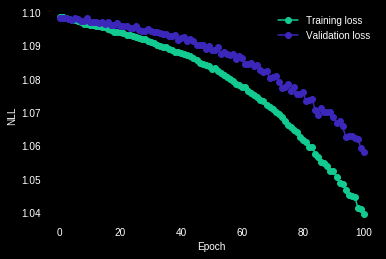

Epoch: 101
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.038 | Train Acc: 71.53%
	 Val. Loss: 1.057 |  Val. Acc: 65.56%
Epoch: 102
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.037 | Train Acc: 70.61%
	 Val. Loss: 1.057 |  Val. Acc: 66.24%
Epoch: 103
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.034 | Train Acc: 71.14%
	 Val. Loss: 1.053 |  Val. Acc: 66.62%
Epoch: 104
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.033 | Train Acc: 71.58%
	 Val. Loss: 1.060 |  Val. Acc: 64.51%
Epoch: 105
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.032 | Train Acc: 71.76%
	 Val. Loss: 1.056 |  Val. Acc: 65.28%
Epoch: 106
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.030 | Train Acc: 71.22%
	 Val. Loss: 1.054 |  Val. Acc: 66.10%
Epoch: 107
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.029 | Train Acc: 71.49%
	 Val. Loss: 1.053 |  Val. Acc: 67.04%
Epoch: 108
Training...
Iteration 149     

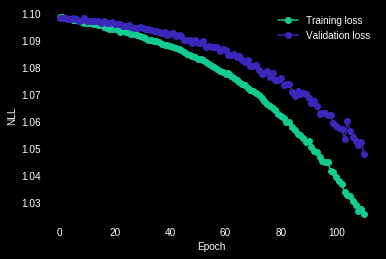

Epoch: 111
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.022 | Train Acc: 72.43%
	 Val. Loss: 1.045 |  Val. Acc: 66.30%
Epoch: 112
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.021 | Train Acc: 71.64%
	 Val. Loss: 1.044 |  Val. Acc: 66.83%
Epoch: 113
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.022 | Train Acc: 71.69%
	 Val. Loss: 1.046 |  Val. Acc: 66.40%
Epoch: 114
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.019 | Train Acc: 71.64%
	 Val. Loss: 1.041 |  Val. Acc: 67.48%
Epoch: 115
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.017 | Train Acc: 71.46%
	 Val. Loss: 1.042 |  Val. Acc: 67.15%
Epoch: 116
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.015 | Train Acc: 71.50%
	 Val. Loss: 1.043 |  Val. Acc: 66.78%
Epoch: 117
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.014 | Train Acc: 71.78%
	 Val. Loss: 1.044 |  Val. Acc: 66.02%
Epoch: 118
Training...
Iteration 149     

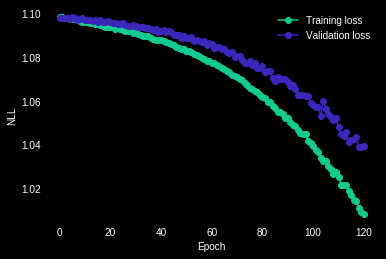

Epoch: 121
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.007 | Train Acc: 71.82%
	 Val. Loss: 1.037 |  Val. Acc: 66.98%
Epoch: 122
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.006 | Train Acc: 72.25%
	 Val. Loss: 1.035 |  Val. Acc: 66.54%
Epoch: 123
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.005 | Train Acc: 71.81%
	 Val. Loss: 1.034 |  Val. Acc: 66.93%
Epoch: 124
Training...
Iteration 149        
Evaluating...
	Train Loss: 1.000 | Train Acc: 71.60%
	 Val. Loss: 1.034 |  Val. Acc: 66.76%
Epoch: 125
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.999 | Train Acc: 71.86%
	 Val. Loss: 1.031 |  Val. Acc: 67.54%
Epoch: 126
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.997 | Train Acc: 72.14%
	 Val. Loss: 1.028 |  Val. Acc: 66.52%
Epoch: 127
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.995 | Train Acc: 71.90%
	 Val. Loss: 1.026 |  Val. Acc: 68.31%
Epoch: 128
Training...
Iteration 149     

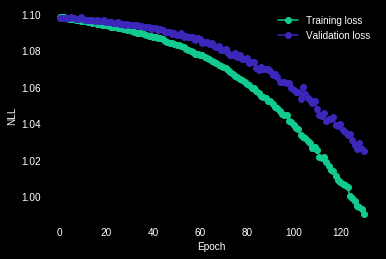

Epoch: 131
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.989 | Train Acc: 72.35%
	 Val. Loss: 1.024 |  Val. Acc: 67.15%
Epoch: 132
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.989 | Train Acc: 71.86%
	 Val. Loss: 1.027 |  Val. Acc: 66.98%
Epoch: 133
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.984 | Train Acc: 72.31%
	 Val. Loss: 1.023 |  Val. Acc: 66.33%
Epoch: 134
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.985 | Train Acc: 72.38%
	 Val. Loss: 1.026 |  Val. Acc: 67.15%
Epoch: 135
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.978 | Train Acc: 72.49%
	 Val. Loss: 1.018 |  Val. Acc: 67.37%
Epoch: 136
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.980 | Train Acc: 71.83%
	 Val. Loss: 1.022 |  Val. Acc: 66.48%
Epoch: 137
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.977 | Train Acc: 72.83%
	 Val. Loss: 1.018 |  Val. Acc: 66.95%
Epoch: 138
Training...
Iteration 149     

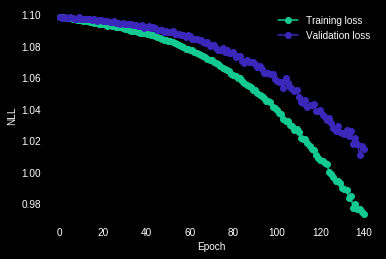

Epoch: 141
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.969 | Train Acc: 72.61%
	 Val. Loss: 1.018 |  Val. Acc: 66.76%
Epoch: 142
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.970 | Train Acc: 72.29%
	 Val. Loss: 1.017 |  Val. Acc: 67.40%
Epoch: 143
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.968 | Train Acc: 72.53%
	 Val. Loss: 1.016 |  Val. Acc: 66.45%
Epoch: 144
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.963 | Train Acc: 73.06%
	 Val. Loss: 1.007 |  Val. Acc: 68.38%
Epoch: 145
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.964 | Train Acc: 72.11%
	 Val. Loss: 1.007 |  Val. Acc: 68.41%
Epoch: 146
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.961 | Train Acc: 73.10%
	 Val. Loss: 1.001 |  Val. Acc: 69.21%
Epoch: 147
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.958 | Train Acc: 73.29%
	 Val. Loss: 1.004 |  Val. Acc: 67.42%
Epoch: 148
Training...
Iteration 149     

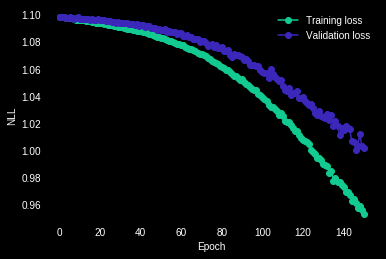

Epoch: 151
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.953 | Train Acc: 72.67%
	 Val. Loss: 1.003 |  Val. Acc: 67.04%
Epoch: 152
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.951 | Train Acc: 72.82%
	 Val. Loss: 0.997 |  Val. Acc: 67.97%
Epoch: 153
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.947 | Train Acc: 72.85%
	 Val. Loss: 1.000 |  Val. Acc: 67.70%
Epoch: 154
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.948 | Train Acc: 72.68%
	 Val. Loss: 1.006 |  Val. Acc: 65.91%
Epoch: 155
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.946 | Train Acc: 72.60%
	 Val. Loss: 1.002 |  Val. Acc: 67.81%
Epoch: 156
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.946 | Train Acc: 72.39%
	 Val. Loss: 0.999 |  Val. Acc: 67.42%
Epoch: 157
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.946 | Train Acc: 72.58%
	 Val. Loss: 0.996 |  Val. Acc: 67.39%
Epoch: 158
Training...
Iteration 149     

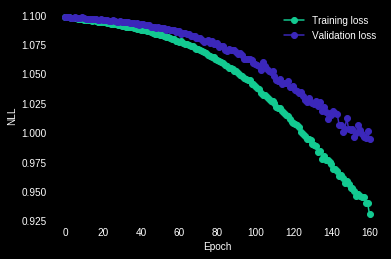

Epoch: 161
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.937 | Train Acc: 73.26%
	 Val. Loss: 0.987 |  Val. Acc: 68.43%
Epoch: 162
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.931 | Train Acc: 73.01%
	 Val. Loss: 0.991 |  Val. Acc: 67.53%
Epoch: 163
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.932 | Train Acc: 73.15%
	 Val. Loss: 0.994 |  Val. Acc: 67.18%
Epoch: 164
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.931 | Train Acc: 73.26%
	 Val. Loss: 1.003 |  Val. Acc: 66.62%
Epoch: 165
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.929 | Train Acc: 73.28%
	 Val. Loss: 0.994 |  Val. Acc: 67.09%
Epoch: 166
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.926 | Train Acc: 73.47%
	 Val. Loss: 0.991 |  Val. Acc: 67.70%
Epoch: 167
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.929 | Train Acc: 73.17%
	 Val. Loss: 0.994 |  Val. Acc: 66.40%
Epoch: 168
Training...
Iteration 149     

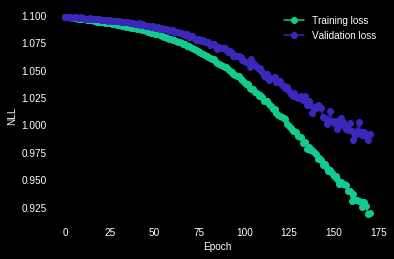

Epoch: 171
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.920 | Train Acc: 73.61%
	 Val. Loss: 0.990 |  Val. Acc: 68.08%
Epoch: 172
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.917 | Train Acc: 73.57%
	 Val. Loss: 0.979 |  Val. Acc: 68.46%
Epoch: 173
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.915 | Train Acc: 73.90%
	 Val. Loss: 0.987 |  Val. Acc: 67.54%
Epoch: 174
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.917 | Train Acc: 72.60%
	 Val. Loss: 0.990 |  Val. Acc: 67.37%
Epoch: 175
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.914 | Train Acc: 73.50%
	 Val. Loss: 0.981 |  Val. Acc: 66.38%
Epoch: 176
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.908 | Train Acc: 73.78%
	 Val. Loss: 1.000 |  Val. Acc: 67.36%
Epoch: 177
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.906 | Train Acc: 74.25%
	 Val. Loss: 0.988 |  Val. Acc: 67.75%
Epoch: 178
Training...
Iteration 149     

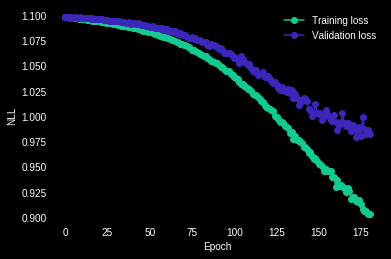

Epoch: 181
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.902 | Train Acc: 74.38%
	 Val. Loss: 0.982 |  Val. Acc: 68.71%
Epoch: 182
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.904 | Train Acc: 73.83%
	 Val. Loss: 0.985 |  Val. Acc: 67.70%
Epoch: 183
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.900 | Train Acc: 73.67%
	 Val. Loss: 0.977 |  Val. Acc: 67.61%
Epoch: 184
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.901 | Train Acc: 73.58%
	 Val. Loss: 0.978 |  Val. Acc: 67.31%
Epoch: 185
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.896 | Train Acc: 73.99%
	 Val. Loss: 0.988 |  Val. Acc: 67.34%
Epoch: 186
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.898 | Train Acc: 73.74%
	 Val. Loss: 0.971 |  Val. Acc: 69.07%
Epoch: 187
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.896 | Train Acc: 73.81%
	 Val. Loss: 0.986 |  Val. Acc: 68.46%
Epoch: 188
Training...
Iteration 149     

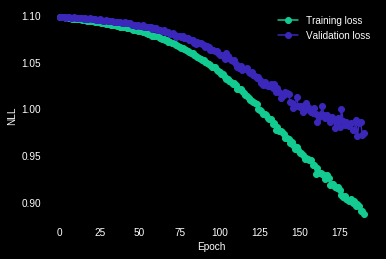

Epoch: 191
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.889 | Train Acc: 73.93%
	 Val. Loss: 0.968 |  Val. Acc: 69.06%
Epoch: 192
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.889 | Train Acc: 74.28%
	 Val. Loss: 0.978 |  Val. Acc: 68.22%
Epoch: 193
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.890 | Train Acc: 74.22%
	 Val. Loss: 0.976 |  Val. Acc: 68.54%
Epoch: 194
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.884 | Train Acc: 74.97%
	 Val. Loss: 0.976 |  Val. Acc: 68.43%
Epoch: 195
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.880 | Train Acc: 74.22%
	 Val. Loss: 0.973 |  Val. Acc: 68.54%
Epoch: 196
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.881 | Train Acc: 74.11%
	 Val. Loss: 0.976 |  Val. Acc: 68.77%
Epoch: 197
Training...
Iteration 149        
Evaluating...
	Train Loss: 0.882 | Train Acc: 74.56%
	 Val. Loss: 0.971 |  Val. Acc: 66.95%
Epoch: 198
Training...
Iteration 149     

In [0]:
N_EPOCHS = 200
model_save_name="ma_rnn.pt"
path = F"/content/drive/My Drive/{model_save_name}"

all_train_loss = []
all_val_loss = []
all_epochs = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print("Epoch: " + str(epoch))
    train_loss, train_acc = train(rnn, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn, testloader, criterion)

    #train_loss  = train(rnn, trainloader, optimizer, criterion)
    #valid_loss  = evaluate(rnn, testloader, criterion)    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn.state_dict(), path)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    all_train_loss.append(train_loss)
    all_val_loss.append(valid_loss)
    all_epochs.append(epoch)

    if not epoch%10 and epoch != 0:
      plot_network(all_epochs, all_train_loss, all_val_loss)

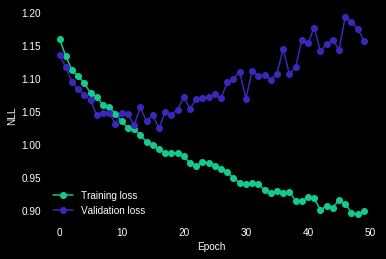

In [0]:
plot_network(all_epochs, all_train_loss, all_val_loss) # with regularization

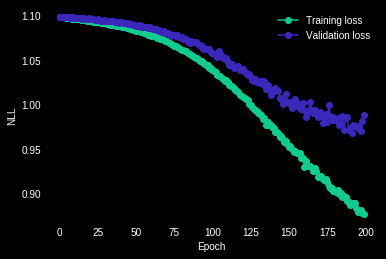

In [0]:
plot_network(all_epochs, all_train_loss, all_val_loss) # without regularization

In [0]:
model_save_name="rnn_embed.pt"
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(rnn.state_dict(), path)